In [1]:
import sys; sys.path.append('../../')
from definitions import *
from notebooks.nb_imports import *

In [2]:
from sklearn.metrics import confusion_matrix
# from src.models.optimizers import ThresholdOptimizer

In [3]:
# Load raw
labels_binary = load_pickle(ROOT_DIR + '/data/processed/labels/original.pickle')
labels_utility = load_pickle(ROOT_DIR + '/data/processed/labels/utility_scores.pickle')
labels = labels_binary.reset_index()
ids_eventual = load_pickle(ROOT_DIR + '/data/processed/labels/ids_eventual.pickle')
num_eventual = len(ids_eventual)

# Drop time and mark 
labels_eventual = pd.Series(index=labels_binary.index.get_level_values('id').unique(), data=0)
labels_eventual.loc[ids_eventual] = 1

# Load preds
probas = load_pickle(ROOT_DIR + '/models/experiments/main/finalised/1/probas.pickle')

/Users/jambo/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [4]:
# Resetting the index will make some calculations easier
probas = probas.reset_index()

# Reproduction of the Plots Seen in DeepMind Kidney Injury

In [5]:
# The probas that exceed the threshold
proba_exceed = probas[probas[0] > 0.12408]

In [6]:
# Get the predicted ids and plot a cm for the given threshold
ids_pred = proba_exceed['id'].unique()
overall_preds = pd.Series(index=labels_binary.index.get_level_values('id').unique(), data=0)
overall_preds.loc[ids_pred] = 1

In [7]:
from sklearn.metrics import precision_score
precision_score(labels_eventual, overall_preds)

0.5001795332136445

In [8]:
# Precision and threshold that attains it
precision_thresholds = {
    20: 0.025,
    33: 0.0632,
    50: 0.12408
}

In [9]:
# Below gives the ids and first time of exceed
exceed_times = proba_exceed.groupby('id', as_index=False).apply(lambda x: x.iloc[0]).set_index('id')['time']

# Find the actual time of sepsis for those with sepsis diagnosis inside the ICU (not before)
actual_times = labels[labels['SepsisLabel'] == 1].groupby('id').apply(lambda x: x.iloc[-3] if x.shape[0] > 3 else None)['time']

In [10]:
# Get the ids that were predicted correctly
ids = [x for x in actual_times.index if x in exceed_times.index]
early_predict = actual_times.loc[ids].values.astype(int) - exceed_times.loc[ids].values.astype(int)
early_predict = early_predict[early_predict < 1000]

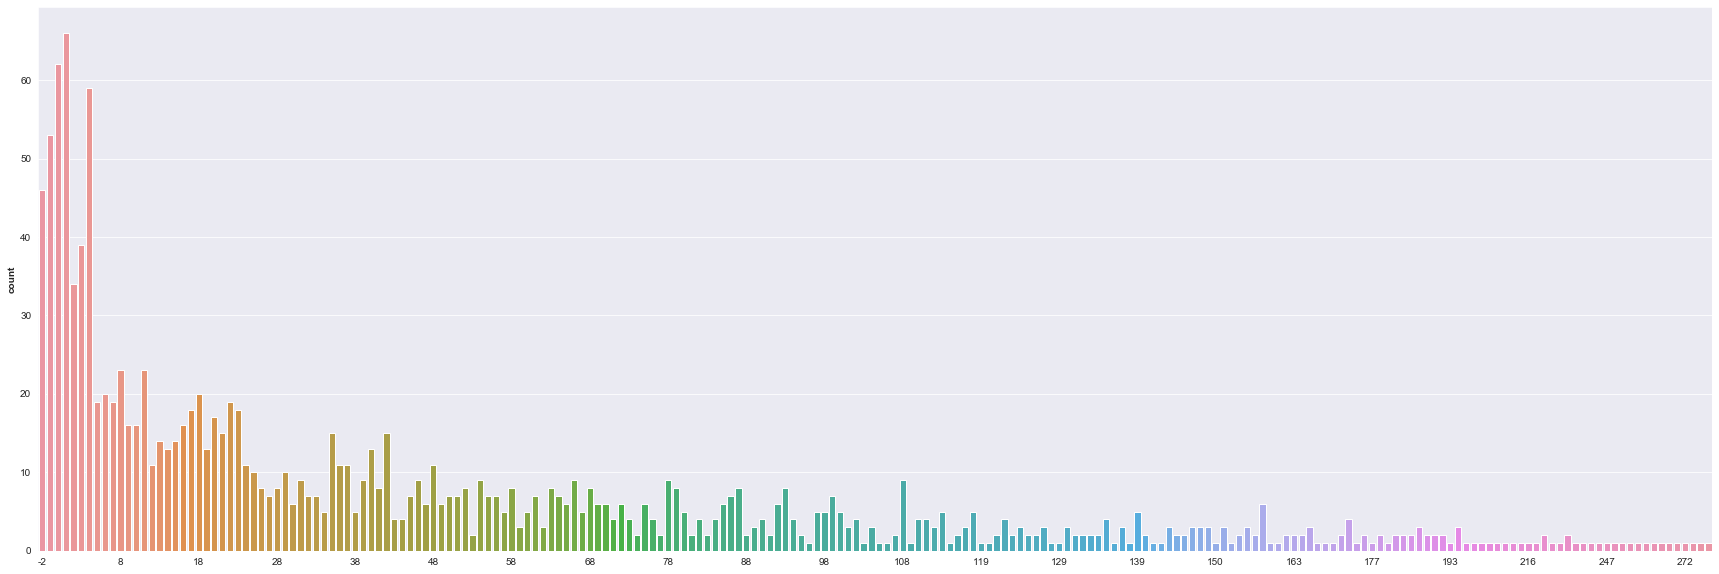

In [11]:
# Plot for early detection
fig, ax = plt.subplots(figsize=(30, 10))
sns.countplot(early_predict, ax=ax)
remove_plot_ticks(ax, n=10)

In [12]:
df = pd.DataFrame(columns=['time', 'percentage', 'precision'])

In [14]:
def func(labels_binary, probas, thresh):
    """
    :param labels_binary: Binary labels
    :param probas: Output probas/regressed values
    :param thresh: Threshold to apply to the probas
    :return:
        overall_preds: The overall predictions (a single 0-1 for each person)
        exceed_times: The time of first exceed for those marked 
        actual_times): The actual time of sepsis for those that get it
    
    """
    # First find the probabilities that exceed the threshold
    proba_exceed = probas[probas[0] > thresh]
    
    # Find the 'overall prediction' for each person, a binary 0, 1 for each individual
    ids_pred = proba_exceed['id'].unique()
    overall_preds = pd.Series(index=labels_binary.index.get_level_values('id').unique(), data=0)
    overall_preds.loc[ids_pred] = 1
    
    # Get the first time the probability exceeds the threshold for each person
    exceed_times = proba_exceed.groupby('id', as_index=False).apply(lambda x: x.iloc[0]).set_index('id')['time']
    
    # Find the actual time of sepsis for those with sepsis diagnosis inside the ICU (not before)
    actual_times = (labels[labels['SepsisLabel'] == 1]
                    .groupby('id')
                    .apply(lambda x: x.iloc[-3] if x.shape[0] > 3 else None)
                    ['time'])
    
    return overall_preds, exceed_times, actual_times

In [15]:
dfs = []
for precision, thresh in precision_thresholds.items():
    # Get information about various times
    overall_preds, exceed_times, actual_times = func(labels_binary, probas, thresh)
    
    # Get the ids that were predicted correctly
    ids = [x for x in actual_times.index if x in exceed_times.index]
    early_predict = actual_times.loc[ids].values.astype(int) - exceed_times.loc[ids].values.astype(int)
    early_predict = early_predict[early_predict < 1000]

    # Find the ends for the bins
    bin_ends = np.array([0, 6, 12, 18, 24, 30, 36, 42, 48])

    # Count the number of predictions made in that region
    counts = []
    for end in bin_ends:
        counts.append(len(early_predict[early_predict >= end]))
    counts = np.array(counts).reshape(-1, 1)
    
    # Make percentages
    pcnts = 100 * counts / num_eventual 
    
    # Now make numpy
    data = np.concatenate([bin_ends.reshape(-1, 1), pcnts, precision * np.ones(shape=(pcnts.shape[0], 1))], axis=1)
    
    # Make a df
    dfs.append(pd.DataFrame(data=data, columns=['time', 'percentage', 'Precision (%)']))

# Make a single df
df = pd.concat(dfs)
df['time'] = df['time'].astype(int)
df['Precision (%)'] = df['Precision (%)'].astype(int)

# Plots
We plot the confusion matrix next to the time graph on the same axis for use in the poster

## Regressor

In [17]:
# We will use 33% precision for the confusion matrix
overall_preds, exceed_times, actual_times = func(labels_binary, probas, precision_thresholds[33])

In [20]:
sns.set_style('darkgrid')

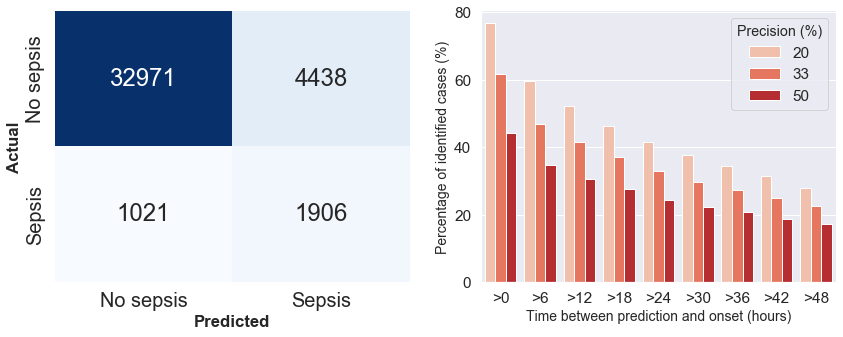

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_confusion_matrix(confusion_matrix(labels_eventual, overall_preds), ax=ax[0], classes=['No sepsis', 'Sepsis'], cmap='Blues')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Plot time to sepsis
sns.barplot(x='time', y='percentage', hue='Precision (%)', data=df, palette='Reds', ax=ax[1])

# Formatting
ax[1].set_xticklabels(['>{}'.format(i) for i in bin_ends])
ax[1].set_xlabel('Time between prediction and onset (hours)', fontsize=14, fontweight='normal')
ax[1].set_ylabel('Percentage of identified cases (%)', fontsize=14, fontweight='normal')

# Save 
plt.savefig('./figures/cm_and_deepmind.png', bbox_inches='tight', dpi=300)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].spines['bottom'].set_visible(False)
# ax[1].spines['left'].set_visible(False)


## Classifier - Binary task

In [31]:
labels, preds = load_pickle(ROOT_DIR + '/models/temp/eventual_preds/labels.pickle'), load_pickle(ROOT_DIR + '/models/temp/eventual_preds/preds.pickle')
labels_max, preds_max = labels.groupby('id').apply(max), preds.groupby('id').apply(max)

/Users/jambo/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [79]:
precision_score(labels.values, (preds > 0.001).astype(int).values)

0.11107388819811752

In [34]:
# Precision and threshold that attains it
precision_thresholds = {
    20: 0.025,
    33: 0.0632,
    50: 0.12408
}

0.7962235528500938

# Utility Values for Different Time-Windows

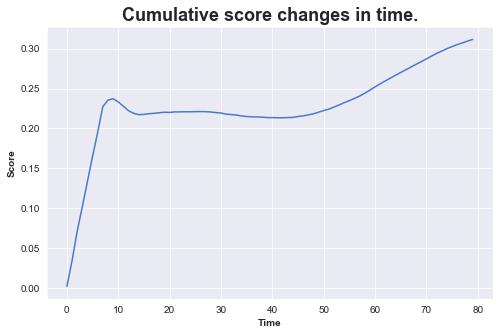

In [16]:
tt, scores = load_pickle(ROOT_DIR + '/reports/random_scripts/scores_up_to_time_t.pickle')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tt, scores)

# Plot things
ax.set_xlabel('Time')
ax.set_ylabel('Score')
ax.set_title('Cumulative score changes in time.', fontsize=18, fontweight='bold')

plt.savefig('./figures/score_change_in_time.png', dpi=300, bbox_inches='tight')